# Coursework: The Museum Protection Problem

In [ ]:
#Run if necessary
!pip install deap

## Import relevant libraries

In [1]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv


# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

## Set up  

Depending on the instance you are trying to solve, sest the following parameters


In [2]:
# Windows and Mac: just set the path to the instance
myinst="/path_to_instance/WallsTest1.csv"
instance_file = myinst  # the name of the file specifying the layout - use "" to represent an empty grid to an empty grid

#  COLAB: upload the instance to colab and
# instance_file = "./name_of_instance_file"

nb_cameras = 5 # number of cameras (specificed in the instance definition)
instance_size  = 100 # number of cells per dimension, i.e total number of cells in the grid is instance_size*instance_size

num_cells = instance_size*instance_size # total number of cells in the grid



In [3]:

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls

walls = np.zeros(instance_size*instance_size)


with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for line in csv_reader:
        column=int(line[0])
        row=int(line[1])
        oneD_index = (row * instance_size) + column;
        walls[oneD_index]=1
        




## Set up the fitness calculations 

This calls an external executable to return a fitness value. You cannot modify the code in this executable. 


1. If you are running code using **Google Colab**, you neyou must upload the executables called "bit_cam_napier_colab"  and "bit_cam_napier_visualisation_colab" to Colab and uncomment the line of code at tge top of the next cell

2. If you are running on **Windows using Anaconda**, then your code needs to call the executables "bit_cam_napier_windows.exe" and "bit_cam_napier_visualisation_windows.exe" - you need to specify the exact path to these on your system in the code below

3. If you are running on **Mac using Anaconda**, then your code needs to call the executables "bit_cam_napier_mac.exe" and "bit_cam_napier_visualisation_mac.exe" - you need to specify the exact path to these on your system in the code below

The call to the external function is wrapped inside an evaluation function called **eval_function()** .. this has the standard form used by DEAP and should be registered with the toolbox as usual. Read the following carefully.    You can any code you wish inside this function but it must always call the external *objective_function()* with a valid solution. This is defined below


 - The external "objective_function" needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1.
- There must be exactly c values set to 1, where c= number of cameras
- Regardless of the representation you use, **you must turn a DEAP individual into a list of the form specified above** before calling the objective_function


**WARNING!!! You should only call the *objective_function* with a list that has exactly *c* bits set to 1**

If this is not the case, then you should assign a fitness value to the individual without calling the external  *objective_function*. You can choose how to set this - the fitness you assign should reflect the fact that the solution is invalid.  For a valid solution, the worst possible fitness is equal to *num_cells*, i.e. no cell is covered. Therefore, the fitness you choose to assign to an invalid solution should be worse than this value

In [13]:

# set the correct binary depending on your machine/setup - you need to choose one of the options below and set the path correctly

# for MacOS
#path_binary = "/path-to-binary/bit_cam_napier_mac"
#path_binary_vis = "/path-to-binary/bit_cam_napier_visualisation_mac"


# On Windows: change the following to the location of the binary on your system
# path_binary = "path-to/bit_cam_napier_windows.exe"
# path_binary_vis = "path-to/bit_cam_napier_visualisation_windows.exe"


# on Colab: YOU MUST UPLOAD THE BINARIES TO COLAB
#!chmod 755 -R ./bit_cam_napier_colab
#!chmod 755 -R ./bit_cam_napier_visualisation_colab


# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)
        


In [5]:
# this is the eval function called from DEAP: you can modify this to adapt the fitness for invalid solutions. The fitness of a valid solution
# is obtained by calling the binary executable

# This is the function where you will likely do most work!

def eval_function(individual):

  solution=[]

  # The fitness function needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1. You must first convert
  # the individual passed to this function (a class) to a list

  # This code assumes your representation of an individual contains a list of 0,1s and is of length num_cells
  # If you have used another representation, you must write your own code to convert it to the form above

  for i in range(0, len(individual)):
    solution.append(individual[i])

  # check how many cameras in the solution - if it does not equal nb_cameras the solution is *invalid*
  # if there are cameras placed on a wall, the solution is also invalid
  # if the solution is invalid, you must decide what fitness to assign - do *not* call the objective_function

  total_cameras = np.sum(solution)
    
  if instance_file == "":
    cameras_on_walls = 0
  else:
    cameras_on_walls = check_walls(solution, instance_file) 
            
                                        
# you will need to modify this code before you can run it
  if  total_cameras > nb_cameras:
    fitness =  # you decide!!!!
  elif total_cameras < nb_cameras:
    fitness =  # you decide!!
  elif cameras_on_walls > 0:
    fitness =  # you decide!
  else:
    # only call this if the solution contains exactly nb_cameras and no cameras on walls,
    fitness = objective_function(solution, instance_size, nb_cameras, instance_file)

  return fitness,

## Set up the DEAP toolbox

This sets up a  very basic EA. It uses standard operators to manipulate a list of 0,1s.  You can change these operators for others from the DEAP toolbox or write your own

In [6]:

# define the fitness class and creare an individual class - set up as a minimisation problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# create a toolbox
toolbox = base.Toolbox()


# Define an individual as a list with each value set to 0 or 1, of length num_cells
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)

#an individual consists of repeated genes of type "attr_bool"  - we specify num_cells genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, num_cells)

#  a population consist of a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)




In [8]:
# main function - this just uses a simple EA - you can modify as you wish, including xhanging the parameters

# choose these parameters yourself!
ngen = 200
popsize = 50

def main():

    # choose a population size: e.g. 50
    pop = toolbox.population(n=popsize)

    # keep track of the single best solution found
    hof = tools.HallOfFame(1)

    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=1.0, mutpb=0.05, ngen=ngen,
                                   stats=stats, halloffame=hof, verbose=False)

    return pop, log, hof

# Experimenting

This runs the basic EA once. You can adapt this to run repeated expts. etc.

In [9]:

##############################
# run the main function
pop, log, hof = main()

##############################


best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list


# look in the logbook to see what generation this was found at

min = log.select("min")  # min fitness per generation stored in log

for i in range(ngen):  # set to ngen
        fit = min[i]
        if fit == best:
            break

print("max fitness found is %s at gen %s " % (best, i))
print("number of cameras is %s" % (np.sum(hof[0])))




max fitness found is 44400000.0 at gen 199 
number of cameras is 4440


## Plotting (optional)

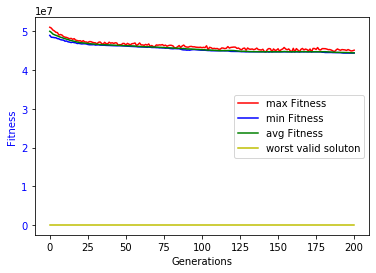

In [10]:
# This is not necessary - but useful to see what is going on for a single run
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()

# set this to the number of generations in the EA
my_gens=ngen
# add a line to indicate "valid solutions" i.e solutions with the correct number of cameras. Any solution below this line is valid
worst_valid = [num_cells]*(my_gens+1)

line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
line4 = ax1.plot(gen, worst_valid, "b-", label="worst valid soluton", color="y" )
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
    
#plt.ylim(0,num_cells+10)   # change the scale on the graph to see the valid solutions better

lns = line1+line2+line3+line4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")



# Visualisation Tools

The code sets up some functions to allow you do visualise solutions. You shouldn't need to alter the code in the cell below (make sure the variable *path_binary_vis* is set to the correct binary at the start)



In [11]:

# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    


### Visualising a solution

Two examples are given:
- visualising a random solution
- visualising an invidual returned from the EA


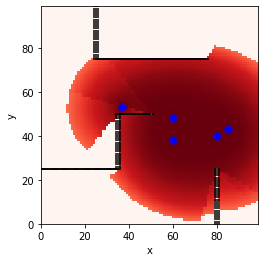

In [14]:
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like


# this assumes a grid of size 100x100 
sol = np.zeros(100*100)

# add some cameras!
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1
sol[random.randint(0, 10000)] = 1

actual_cameras=sum(sol)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")

# choose a layout


visualise_objective_function(sol, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


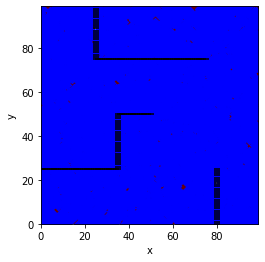

In [15]:
# here we visualise the best result returned from the algorithm - it assumes an individual is a list of 0,1s. 
# If your individual uses a different representation then adapt accordingly to reshape into this form

# first we need to turn the individual returned into a list
best_solution=[]
for i in range(0, len(hof[0])):
    best_solution.append(hof[0][i])
    
actual_cameras=sum(best_solution)  # need to give number of cameras in the solution

visualise_objective_function(best_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)